In [152]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import torch
import torch.nn as nn


import seaborn as sns
# Set up some parameters for pretty plots
import matplotlib as mpl
sns.set_style('whitegrid')
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'

plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# Colors & styles adjustments for better visibility on both backgrounds
text_and_line_color = '#808080'
plt.rcParams['text.color'] = text_and_line_color
plt.rcParams['axes.labelcolor'] = text_and_line_color
plt.rcParams['xtick.color'] = text_and_line_color
plt.rcParams['ytick.color'] = text_and_line_color
plt.rcParams['axes.edgecolor'] = text_and_line_color



In [2]:
# L_1 Optimizer
class SGD_L1(torch.optim.SGD):
    def __init__(self, params, l1_lambda=0.01, *args, **kwargs):
        super(SGD_L1, self).__init__(params, *args, **kwargs)
        self.l1_lambda = l1_lambda

    @torch.no_grad()
    def step(self, closure=None):
        # standard SGD step
        loss = super(SGD_L1, self).step(closure)  

        # Soft thresholding
        for group in self.param_groups:
            for p in group['params']:
                p.data = torch.sign(p.data) * torch.clamp(torch.abs(p.data) - self.l1_lambda, min=0)

        return loss

## First example, linear sparse teacher

In [3]:
#### Functions

# Define the training loss function (as defined earlier)
def training_loss_fn(S, T, Sigma):
    difference = S - T
    loss = difference @ Sigma @ difference/2
    return loss

# Define the validation loss function
def validation_loss_fn(S, T):
    difference = S - T
    return torch.dot(difference, difference)/2




def get_extreme_eigenvalues(matrix):
    """Returns the smallest and largest non-vanishing eigenvalues of the matrix."""
    eigenvalues, _ = torch.linalg.eigh(matrix)
    sorted_eigenvalues = torch.sort(eigenvalues)[0]
    
    non_vanishing_eigenvalues = sorted_eigenvalues[sorted_eigenvalues > 1e-5]
    
    if len(non_vanishing_eigenvalues) == 0:
        raise ValueError("All eigenvalues are vanishing!")
    
    min_eigenvalue = non_vanishing_eigenvalues[0]
    max_eigenvalue = non_vanishing_eigenvalues[-1]
    
    return min_eigenvalue, max_eigenvalue

def compute_optimal_hyperparameters(matrix):
    """
    Compute all optimal hyperparameters. 
    Following the wonderful Distil article "Why Momentum Really Works"
    (https://distill.pub/2017/momentum/)
    The only differnces are that when an L_2 norm is included: 
    1. The minimal eigenvalue is WD
    2. The maximal eigenvalue is WD+lamnda_max
    3. WD is chose such that the convergence rate is the same inn both cases
    """
    
    # eigenvalues
    min_eigenvalue, max_eigenvalue=get_extreme_eigenvalues(matrix)

    # Optimal weight decay
    WD = max_eigenvalue * min_eigenvalue / (max_eigenvalue - min_eigenvalue)
    
    # Learning rates without momentum
    LR_0 = 2 / (max_eigenvalue + min_eigenvalue)
    LR_WD = 2 / (max_eigenvalue + 2 * WD)
    
    # Learning rates with momentum
    LR_beta = (2 / (torch.sqrt(max_eigenvalue) + torch.sqrt(min_eigenvalue)))**2
    LR_beta_WD = (2 / (torch.sqrt(max_eigenvalue + WD) + torch.sqrt(WD)))**2
    
    # Optimal momentum values
    beta_0 = ((torch.sqrt(max_eigenvalue) - torch.sqrt(min_eigenvalue)) / 
              (torch.sqrt(max_eigenvalue) + torch.sqrt(min_eigenvalue)))**2
    beta_lam = ((torch.sqrt(max_eigenvalue + WD) - torch.sqrt(WD)) / 
                (torch.sqrt(max_eigenvalue + WD) + torch.sqrt(WD)))**2
    
    return {
        "WD": WD,
        "LR_0": LR_0,
        "LR_WD": LR_WD,
        "LR_beta": LR_beta,
        "LR_beta_WD": LR_beta_WD,
        "beta_0": beta_0,
        "beta_lam": beta_lam
    }

In [141]:
#### Training loop

def train_model(num_runs=100, epochs=500, sparse_teacher=False, lr_L1=0.4,l1_lambda=0.0005):
    # Setting up random seeds for reproducibility
    torch.manual_seed(98736)

    # inits
    n = 1000        # Dimension
    q = 7/10        # Fraction of training data (N_tr=q*n)

    if sparse_teacher:
        q_sparse = 6/10    # Sparsity fraction of T
        n_zeros = int(q_sparse*n)
        t = torch.randn(n-n_zeros)
        t = t / torch.norm(t)
        T = torch.cat((t, torch.zeros(n_zeros)), 0)
    else:
        T = torch.randn(n)
        T = T / torch.norm(T)

    # Initialize student vector
    Si = torch.nn.Parameter(torch.randn(n)/np.sqrt(q*n))

    # Lists to store all loss histories for each run
    loss_histories = {
        "no_WD": [],
        "WD": [],
        "SGD_L1": []
    }

    for run in tqdm.trange(num_runs):
        # Generate new data
        X = torch.randn(int(q*n), n)
        Sigma = X.T @ X / (q*n)
    
        # Compute optimal hyperparameters
        hyperparameters = compute_optimal_hyperparameters(Sigma)
    
        # Reset initial student vectors
        S_no_WD = Si.clone().detach().requires_grad_(True)
        S_WD = Si.clone().detach().requires_grad_(True)
        S_SGD_L1 = Si.clone().detach().requires_grad_(True)
    
        # Initialize optimizers with computed hyperparameters
        optimizer_no_WD = torch.optim.SGD([S_no_WD], lr=hyperparameters["LR_0"])
        optimizer_WD = torch.optim.SGD([S_WD], lr=hyperparameters["LR_WD"], weight_decay=hyperparameters["WD"])
        optimizer_SGD_L1 = SGD_L1([S_SGD_L1], l1_lambda=l1_lambda, lr=lr_L1)
    
        # Track loss history for each method
        loss_histories_for_run = {
            "no_WD": [validation_loss_fn(S_no_WD, T).item()],
            "WD": [validation_loss_fn(S_WD, T).item()],
            "SGD_L1": [validation_loss_fn(S_SGD_L1, T).item()]
        }
    
        for epoch in range(epochs):
            for method, optimizer in zip(loss_histories.keys(), [optimizer_no_WD, optimizer_WD, optimizer_SGD_L1]):
                optimizer.zero_grad()
                S = {
                    "no_WD": S_no_WD, 
                    "WD": S_WD, 
                    "SGD_L1": S_SGD_L1
                }[method]
            
                # Forward pass
                loss = training_loss_fn(S, T, Sigma)
            
                # Backward pass
                loss.backward()
            
                # Optimizer step
                optimizer.step()
            
                # Append history
                loss_histories_for_run[method].append(validation_loss_fn(S, T).item())
                
        # Append loss histories for this run
        for method in loss_histories.keys():
            loss_histories[method].append(loss_histories_for_run[method])
    
    return loss_histories, S_SGD_L1, T


In [142]:
loss_histories_random,_,_=train_model(num_runs=100, epochs=500, sparse_teacher=False, lr_L1=0.4,l1_lambda=0.0005)
loss_histories_sparse, S_f, T=train_model(num_runs=100, epochs=500, sparse_teacher=True, lr_L1=0.4,l1_lambda=0.0005)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:39<00:00,  2.56it/s]


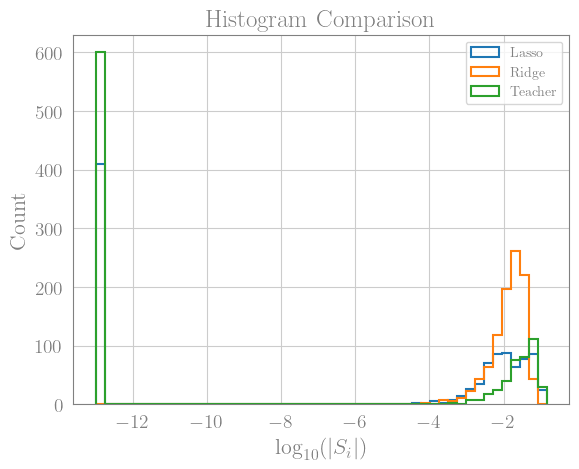

In [151]:
# Define your data
data1 = torch.log10(torch.abs(S_f)+1e-13).detach().numpy()
data2 = torch.log10(torch.abs(S_WD)+1e-13).detach().numpy()
data3 = torch.log10(torch.abs(T)+1e-13).detach().numpy()

# Create the histogram for the first dataset and collect the bin edges
n, bins, patches = plt.hist(data1, 50, histtype='step', linewidth=1.5, label='Lasso')

# Use the collected bin edges for the second histogram
plt.hist(data2, bins=bins, histtype='step', linewidth=1.5, label='Ridge')
plt.hist(data3, bins=bins, histtype='step', linewidth=1.5, label='Teacher')

# Other plot settings
plt.legend(loc='upper right')
plt.xlabel(r'$\log_{10}(|S_i|)$')
plt.ylabel('Count')
plt.title('Histogram Comparison')

plt.show()


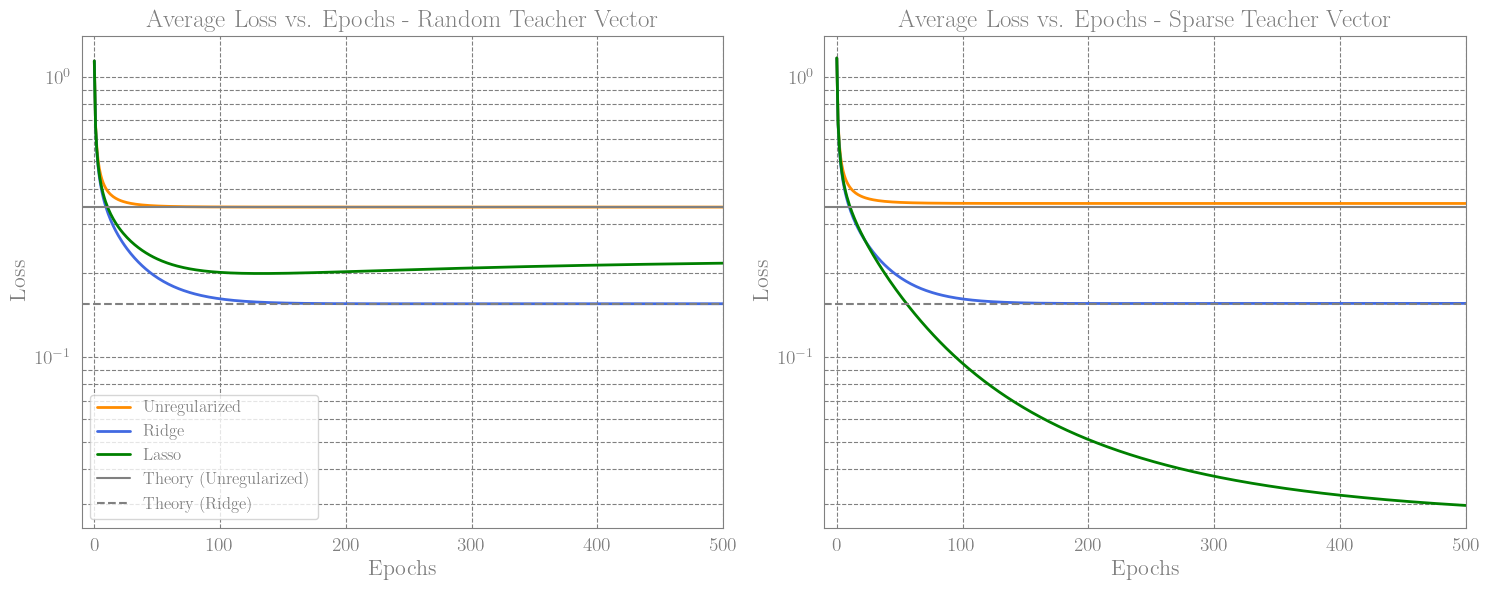

In [105]:
# Assuming you have avg_loss_histories_random computed as well
avg_loss_histories_sparse = {method: np.mean(loss_histories_sparse[method], axis=0) for method in loss_histories_sparse}
avg_loss_histories_random = {method: np.mean(loss_histories_random[method], axis=0) for method in loss_histories_random}

colors = {
    "no_WD": "darkorange",
    "WD": "royalblue",
    "SGD_L1": "green"
}

linestyles = {
    "no_WD": "-",
    "WD": "-",
    "SGD_L1": "-"
}

labels = {
    "no_WD": r"Unregularized",
    "WD": r"Ridge",
    "SGD_L1": r"Lasso"
}

text_and_line_color = "gray"
order = ["no_WD", "WD", "SGD_L1"]

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot for Random Teacher
for method in order:
    axs[0].semilogy(avg_loss_histories_random[method], label=labels[method], color=colors[method], linestyle=linestyles[method], linewidth=2)

axs[0].axhline((1-q) * ((Si - T) @ (Si - T)).item()/2, color=text_and_line_color, ls='-', label=r"Theory (Unregularized)")
axs[0].axhline((1-q)*1.03/2, color=text_and_line_color, ls='--', label=r"Theory (Ridge)")
axs[0].set_title(r'Average Loss vs. Epochs - Random Teacher Vector')
axs[0].set_xlabel(r'Epochs')
axs[0].set_ylabel(r'Loss')
axs[0].set_xlim(-10, 500)
axs[0].legend(fontsize=12, loc='lower left')
axs[0].grid(True, which="both", ls="--", c=text_and_line_color)

# Plot for Sparse Teacher
for method in order:
    axs[1].semilogy(avg_loss_histories_sparse[method], label=labels[method], color=colors[method], linestyle=linestyles[method], linewidth=2)

axs[1].axhline((1-q) * ((Si - T) @ (Si - T)).item()/2, color=text_and_line_color, ls='-', label=r"Theory (No WD)")
axs[1].axhline((1-q)*1.03/2, color=text_and_line_color, ls='--', label=r"Theory (With WD)")
axs[1].set_title(r'Average Loss vs. Epochs - Sparse Teacher Vector')
axs[1].set_xlabel(r'Epochs')
axs[1].set_ylabel(r'Loss')
axs[1].set_xlim(-10, 500)

axs[1].grid(True, which="both", ls="--", c=text_and_line_color)



# Set the y-limits for both axes
axs[0].set_ylim(*axs[1].get_ylim())


plt.tight_layout()

plt.savefig('/Users/nadavoutmezguine/Library/CloudStorage/Dropbox/Mac/Documents/Nadav-out.github.io/assets/images/gen_linear_sparse.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()


## Two layers

In [153]:
class TwoLayerLinear(nn.Module):
    def __init__(self, D, v):
        super(TwoLayerLinear, self).__init__()
        self.M = nn.Parameter(torch.randn(D, v))
        self.V = nn.Parameter(torch.randn(v))

    def forward(self):
        return torch.matmul(self.M, self.V)

def train_model(num_runs=100, epochs=500, lr_L1=0.4, l1_lambda=0.0005):
    # Setting up random seeds for reproducibility
    torch.manual_seed(98736)

    # inits
    D = 1000  # Size of teacher vector T and dimension of X's second dimension
    v = 100   # Intermediate representation size
    q = 7/100 # Fraction of training data (N_tr=q*n)

    T = torch.randn(D)
    T = T / torch.norm(T)

    # Initialize student network
    student_init = TwoLayerLinear(D, v)
    
    # Lists to store all loss histories for each run
    loss_histories = {
        "no_WD": [],
        "WD": [],
        "SGD_L1": []
    }

    for run in tqdm.trange(num_runs):
        # Generate new data
        X = torch.randn(int(q*D), D)

        # Reset initial student network
        student_no_WD = TwoLayerLinear(D, v)
        student_no_WD.load_state_dict(student_init.state_dict())

        student_WD = TwoLayerLinear(D, v)
        student_WD.load_state_dict(student_init.state_dict())

        student_SGD_L1 = TwoLayerLinear(D, v)
        student_SGD_L1.load_state_dict(student_init.state_dict())

        # Initialize optimizers
        optimizer_no_WD = torch.optim.SGD(student_no_WD.parameters(), lr=0.001)
        optimizer_WD = torch.optim.SGD(student_WD.parameters(), lr=0.001, weight_decay=0.01)
        optimizer_SGD_L1 = SGD_L1(student_SGD_L1.parameters(), l1_lambda=l1_lambda, lr=lr_L1)

        # Track loss history for each method
        loss_histories_for_run = {
            "no_WD": [],
            "WD": [],
            "SGD_L1": []
        }

        for epoch in range(epochs):
            for method, optimizer, student in zip(
                loss_histories.keys(), 
                [optimizer_no_WD, optimizer_WD, optimizer_SGD_L1], 
                [student_no_WD, student_WD, student_SGD_L1]):

                optimizer.zero_grad()
                
                MV_product = student()

                # Compute the loss
                loss = torch.norm(X @ (T - MV_product))**2

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                # Append loss to history
                loss_histories_for_run[method].append(loss.item())

        # Append loss histories for this run
        for method in loss_histories.keys():
            loss_histories[method].append(loss_histories_for_run[method])
    
    return loss_histories, student_SGD_L1, T

In [155]:
loss_histories=train_model(num_runs=1, epochs=500, lr_L1=0.4, l1_lambda=0.0005)



  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


In [157]:
loss_histories

({'no_WD': [[5807506.0,
    1.0692692525907653e+20,
    inf,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
   

In [156]:
avg_loss_histories = {method: np.mean(loss_histories[method], axis=0) for method in loss_histories}


TypeError: tuple indices must be integers or slices, not dict